In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debashish0sarker","key":"889ec46e790212e1771d258ca88d6db4"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!mv kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list


ref                                                          title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
yashdevladdha/uber-ride-analytics-dashboard                  Uber Data Analytics Dashboard                         17324552  2025-08-08 11:13:42.920000          29529        682  1.0              
mdsultanulislamovi/student-stress-monitoring-datasets        Student Stress Monitoring Datasets                       24336  2025-07-24 16:30:01.617000          16597        292  1.0              
navjotkaushal/coffee-sales-dataset                           Coffee Sales Dataset                                     38970  2025-08-19 09:37:30.057000           3125         39  0.8235294        
pratyushpuri/mu

In [7]:
!kaggle datasets download -d debashish0sarker/captcha-shortened



Dataset URL: https://www.kaggle.com/datasets/debashish0sarker/captcha-shortened
License(s): unknown
100% 3.34G/3.35G [00:21<00:00, 39.7MB/s]
100% 3.35G/3.35G [00:21<00:00, 166MB/s] 


In [8]:
!unzip captcha-shortened.zip -d captcha_shortened


Streaming output truncated to the last 5000 lines.
  inflating: captcha_shortened/SPHINX_shortened/ZOUA_378480.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUB_423764.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUC_118519.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUC_601525.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUF_386752.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUG_855976.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUI_232716.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUI_709128.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUJ_524944.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUJ_814891.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUO_195100.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUO_317513.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUP_563916.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUQ_404157.png  
  inflating: captcha_shor

In [9]:
# Install required packages (torch/torchvision are preinstalled on Kaggle)
!pip install -q torchsummary

import os
import sys
import math
import random
import string
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
from IPython.display import display, FileLink


In [15]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# Hyperparameters
BATCH_SIZE     = 64
EPOCHS         = 10
LEARNING_RATE  = 1e-3
NUM_CHARS      = 4                      # captcha length
ALPHABET       = string.ascii_uppercase # A-Z
NUM_CLASSES    = len(ALPHABET)
VAL_SPLIT      = 0.2

# Training options
USE_AMP = True                          # automatic mixed precision for speed
NUM_WORKERS = 2                         # Kaggle is fine with 2
PIN_MEMORY  = device.type == "cuda"

# Checkpointing
CKPT_DIR = "/content/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
LATEST_CKPT = os.path.join(CKPT_DIR, "latest_checkpoint (1).pth")
BEST_CKPT   = os.path.join(CKPT_DIR, "best_model (1).pth")

# Data directory (UPDATE THIS)
DATA_DIR = "/content/captcha_shortened/SPHINX_shortened"


Using device: cuda


In [16]:
class CAPTCHADataset(Dataset):
    """
    Expects filenames like 'ABCD_xxx.png' where the first 4 chars are the label.
    Uses only uppercase A-Z characters.
    """
    def __init__(self, data_dir, transform=None, num_chars=4, alphabet=string.ascii_uppercase):
        self.data_dir = data_dir
        self.transform = transform
        self.num_chars = num_chars
        self.alphabet = alphabet

        self.char_to_idx = {c: i for i, c in enumerate(self.alphabet)}
        self.idx_to_char = {i: c for c, i in self.char_to_idx.items()}

        self.image_paths, self.labels = [], []

        for fname in sorted(os.listdir(data_dir)):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                # label is first num_chars characters before underscore
                label_str = fname.split("_")[0][:num_chars].upper()
                if len(label_str) == num_chars and all(c in self.alphabet for c in label_str):
                    self.image_paths.append(os.path.join(data_dir, fname))
                    label_indices = [self.char_to_idx[c] for c in label_str]
                    self.labels.append(torch.tensor(label_indices, dtype=torch.long))

        if len(self.image_paths) == 0:
            raise RuntimeError(f"No valid images found in {data_dir}. Check filenames and path.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Convert to grayscale
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        label = self.labels[idx]                   # shape [num_chars]

        if self.transform:
            image = self.transform(image)          # shape [1, H, W] after transform

        return image, label

# Transforms: resize to a stable size; normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((40, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


In [17]:
def get_data_loaders(data_dir, batch_size=64, val_split=0.2):
    dataset = CAPTCHADataset(data_dir, transform=transform, num_chars=NUM_CHARS, alphabet=ALPHABET)

    # Safe split (ensure at least 1 sample in val if possible)
    val_size = max(1, int(len(dataset) * val_split)) if len(dataset) > 1 else 0
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    print(f"📊 Dataset loaded: {len(dataset)} images")
    print(f"📈 Training: {len(train_dataset)} images")
    print(f"📉 Validation: {len(val_dataset)} images")

    # expose for inference helpers
    return dataset, train_loader, val_loader

dataset, train_loader, val_loader = get_data_loaders(DATA_DIR, BATCH_SIZE, VAL_SPLIT)


📊 Dataset loaded: 370142 images
📈 Training: 296114 images
📉 Validation: 74028 images


In [18]:
class CAPTCHA_CNN(nn.Module):
    def __init__(self, num_chars=4, num_classes=26):
        super().__init__()
        self.num_chars = num_chars
        self.num_classes = num_classes

        self.features = nn.Sequential(
            # [B, 1, 40, 150]
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),   # [B, 32, 20, 75]
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),  # [B, 64, 10, 37]
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),# [B, 128, 5, 18]
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256), nn.MaxPool2d(2),# [B, 256, 2, 9]
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d((1, 9))  # [B, 512, 1, 9]
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 9, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_chars * num_classes)
        )

    def forward(self, x):
        x = self.features(x)              # [B, 512, 1, 9]
        x = x.view(x.size(0), -1)         # [B, 512*9]
        x = self.classifier(x)            # [B, num_chars*num_classes]
        return x.view(x.size(0), self.num_chars, self.num_classes)  # [B, C, K]

model = CAPTCHA_CNN(num_chars=NUM_CHARS, num_classes=NUM_CLASSES).to(device)
print("Model created:")
summary(model, (1, 40, 150))


Model created:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 40, 150]             320
              ReLU-2          [-1, 32, 40, 150]               0
       BatchNorm2d-3          [-1, 32, 40, 150]              64
         MaxPool2d-4           [-1, 32, 20, 75]               0
            Conv2d-5           [-1, 64, 20, 75]          18,496
              ReLU-6           [-1, 64, 20, 75]               0
       BatchNorm2d-7           [-1, 64, 20, 75]             128
         MaxPool2d-8           [-1, 64, 10, 37]               0
            Conv2d-9          [-1, 128, 10, 37]          73,856
             ReLU-10          [-1, 128, 10, 37]               0
      BatchNorm2d-11          [-1, 128, 10, 37]             256
        MaxPool2d-12           [-1, 128, 5, 18]               0
           Conv2d-13           [-1, 256, 5, 18]         295,168
             ReLU-14    

In [19]:
criterion = nn.CrossEntropyLoss()  # per-position classification
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=3,
    factor=0.5,
    mode='min'  # remove verbose=True
)

scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

# Decoding helpers
IDX_TO_CHAR = {i: c for i, c in enumerate(ALPHABET)}
CHAR_TO_IDX = {c: i for i, c in IDX_TO_CHAR.items()}

def decode_indices(indices_row):
    return "".join(IDX_TO_CHAR[i] for i in indices_row)

def accuracy_metrics(preds, labels):
    """
    preds: [B, C] long
    labels: [B, C] long
    returns: per_char_acc, full_seq_acc
    """
    per_char_correct = (preds == labels).sum().item()
    per_char_total   = labels.numel()

    seq_correct = (preds == labels).all(dim=1).sum().item()
    seq_total   = labels.size(0)

    return (per_char_correct / per_char_total), (seq_correct / seq_total)


/tmp/ipython-input-3208040303.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [20]:
def save_checkpoint(state, path):
    torch.save(state, path)

def load_latest_if_available(model, optimizer, scheduler, history):
    start_epoch = 0
    best_val_seq_acc = 0.0
    best_epoch = 0

    if os.path.exists(LATEST_CKPT):
        print("🔄 Loading latest checkpoint...")
        ckpt = torch.load(LATEST_CKPT, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        scheduler.load_state_dict(ckpt["scheduler_state_dict"])
        start_epoch = ckpt["epoch"] + 1
        history.update(ckpt["history"])
        best_val_seq_acc = ckpt.get("best_val_seq_acc", 0.0)
        best_epoch = ckpt.get("best_epoch", 0)
        print(f"✅ Resumed from epoch {start_epoch}")
    return start_epoch, best_val_seq_acc, best_epoch

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    history = {
        "train_loss": [], "val_loss": [],
        "train_char_acc": [], "val_char_acc": [],
        "train_seq_acc": [],  "val_seq_acc": []
    }
    start_epoch, best_val_seq_acc, best_epoch = load_latest_if_available(model, optimizer, scheduler, history)

    for epoch in range(start_epoch, epochs):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        running_char_correct = 0
        running_char_total = 0
        running_seq_correct = 0
        running_seq_total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=USE_AMP):
                outputs = model(images)  # [B, C, K]
                loss = criterion(outputs.view(-1, NUM_CLASSES), labels.view(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            preds = outputs.argmax(dim=2)              # [B, C]
            pc_acc, seq_acc = accuracy_metrics(preds, labels)
            running_char_correct += pc_acc * labels.numel()
            running_char_total   += labels.numel()
            running_seq_correct  += seq_acc * labels.size(0)
            running_seq_total    += labels.size(0)

            pbar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss   = running_loss / len(train_loader)
        train_char_acc   = running_char_correct / running_char_total
        train_seq_acc    = running_seq_correct / running_seq_total

        # ---- Validate ----
        model.eval()
        val_running_loss = 0.0
        val_char_corr = 0
        val_char_tot  = 0
        val_seq_corr  = 0
        val_seq_tot   = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs.view(-1, NUM_CLASSES), labels.view(-1))
                val_running_loss += loss.item()

                preds = outputs.argmax(dim=2)
                pc_acc, seq_acc = accuracy_metrics(preds, labels)
                val_char_corr += pc_acc * labels.numel()
                val_char_tot  += labels.numel()
                val_seq_corr  += seq_acc * labels.size(0)
                val_seq_tot   += labels.size(0)

        avg_val_loss   = val_running_loss / max(1, len(val_loader))
        val_char_acc   = (val_char_corr / val_char_tot) if val_char_tot > 0 else 0.0
        val_seq_acc    = (val_seq_corr  / val_seq_tot)  if val_seq_tot  > 0 else 0.0

        scheduler.step(avg_val_loss)

        # Log
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_char_acc"].append(train_char_acc)
        history["val_char_acc"].append(val_char_acc)
        history["train_seq_acc"].append(train_seq_acc)
        history["val_seq_acc"].append(val_seq_acc)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Char Acc: {train_char_acc*100:.2f}% | Train Seq Acc: {train_seq_acc*100:.2f}%")
        print(f"Val   Loss: {avg_val_loss:.4f} | Val   Char Acc: {val_char_acc*100:.2f}% | Val   Seq Acc: {val_seq_acc*100:.2f}%")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # ---- Save latest ----
        latest_state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "history": history,
            "best_val_seq_acc": best_val_seq_acc,
            "best_epoch": best_epoch,
        }
        save_checkpoint(latest_state, LATEST_CKPT)

        # ---- Save epoch checkpoint ----
        epoch_ckpt_path = os.path.join(CKPT_DIR, f"epoch_{epoch+1:03d}.pth")
        save_checkpoint(latest_state, epoch_ckpt_path)
        print(f"📁 Checkpoint saved: {epoch_ckpt_path}")

        # ---- Save best (by full-sequence accuracy) ----
        if val_seq_acc > best_val_seq_acc:
            best_val_seq_acc = val_seq_acc
            best_epoch = epoch + 1
            best_state = {
                "epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "val_char_acc": val_char_acc,
                "val_seq_acc": val_seq_acc,
                "config": {"num_chars": NUM_CHARS, "num_classes": NUM_CLASSES}
            }
            save_checkpoint(best_state, BEST_CKPT)
            print(f"🏆 New BEST model saved (Seq Acc: {val_seq_acc*100:.2f}% at epoch {best_epoch})")

        print("-" * 60)

    # ---- Save final model ----
    final_path = os.path.join(CKPT_DIR, "final_model.pth")
    torch.save({
        "epoch": EPOCHS,
        "model_state_dict": model.state_dict(),
        "final_history": history
    }, final_path)
    print(f"🎉 Training completed.")
    print(f"🏆 Best full-sequence val accuracy: {best_val_seq_acc*100:.2f}% at epoch {best_epoch}")

    return history


In [21]:
print("🚀 Starting training...")
history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS)


🚀 Starting training...
🔄 Loading latest checkpoint...
✅ Resumed from epoch 10
🎉 Training completed.
🏆 Best full-sequence val accuracy: 98.39% at epoch 9


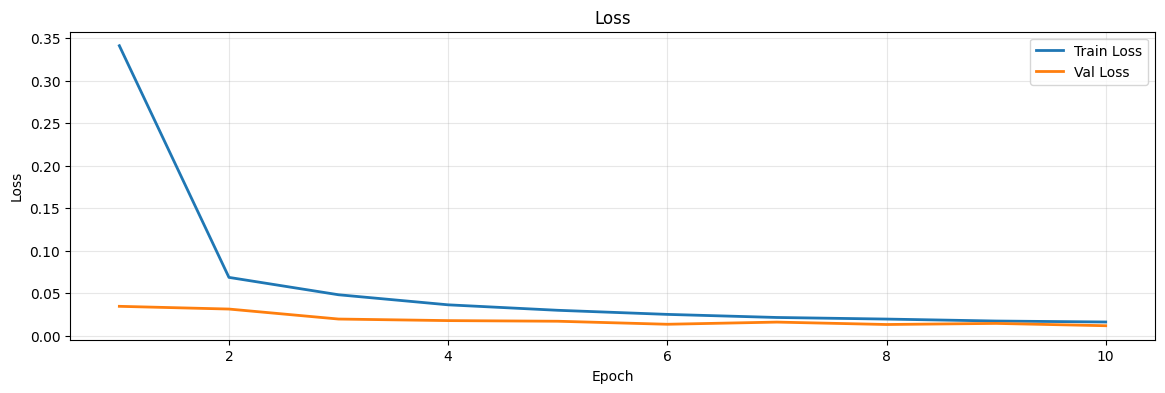

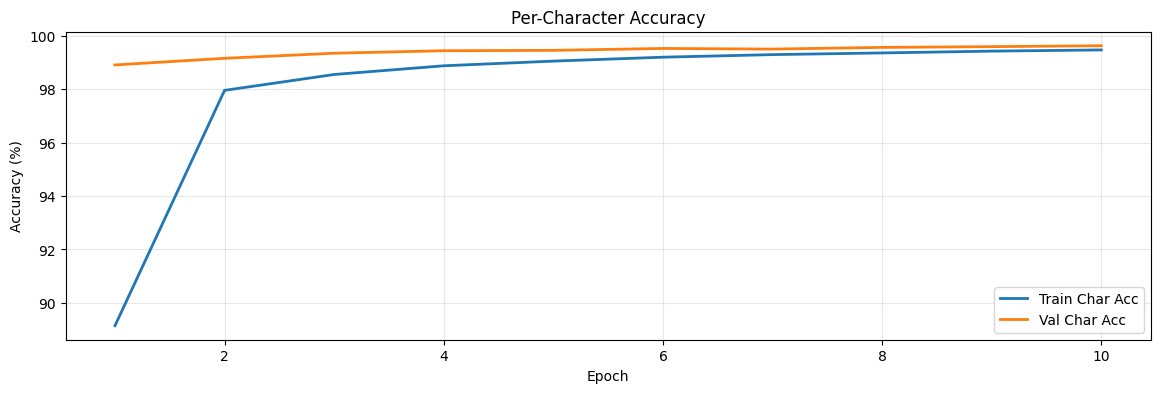

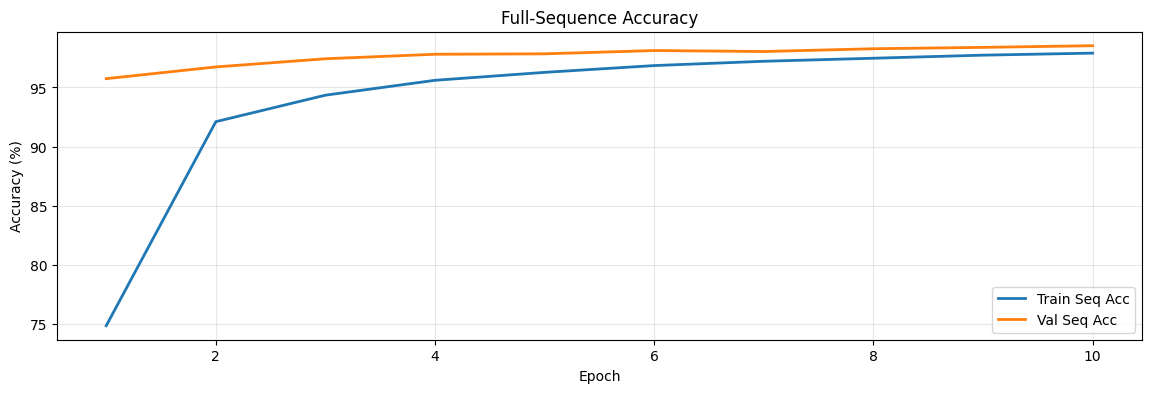

In [ ]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(14,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss", linewidth=2)
    plt.plot(epochs, history["val_loss"],   label="Val Loss", linewidth=2)
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

    plt.figure(figsize=(14,4))
    plt.plot(epochs, np.array(history["train_char_acc"])*100, label="Train Char Acc", linewidth=2)
    plt.plot(epochs, np.array(history["val_char_acc"])*100,   label="Val Char Acc", linewidth=2)
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Per-Character Accuracy"); plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

    plt.figure(figsize=(14,4))
    plt.plot(epochs, np.array(history["train_seq_acc"])*100, label="Train Seq Acc", linewidth=2)
    plt.plot(epochs, np.array(history["val_seq_acc"])*100,   label="Val Seq Acc", linewidth=2)
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Full-Sequence Accuracy"); plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

plot_history(history)


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import torch

def evaluate_with_metrics(model, data_loader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="🔍 Evaluating with Precision/Recall/F1"):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)  # [B, C, K]
            preds = outputs.argmax(dim=2)  # [B, C]

            # Flatten to token-level
            all_preds.extend(preds.cpu().numpy().reshape(-1))
            all_labels.extend(labels.cpu().numpy().reshape(-1))

    # Remove padding (if you used a pad index like -100 or 0 for blanks)
    all_preds = [p for p, l in zip(all_preds, all_labels) if l != -100]
    all_labels = [l for l in all_labels if l != -100]

    print("📊 Classification Report (per-character):")
    print(classification_report(all_labels, all_preds, digits=4))

    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall    = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1        = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return precision, recall, f1


def load_final_and_evaluate(final_path, val_loader):
    if not os.path.exists(final_path):
        print("❌ Final model not found!")
        return None

    ckpt = torch.load(final_path, map_location=device)
    model = CAPTCHA_CNN(num_chars=NUM_CHARS, num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    print(f"✅ Final model loaded (epoch={ckpt.get('epoch','?')})")
    history = ckpt.get("final_history", {})

    precision, recall, f1 = evaluate_with_metrics(model, val_loader, device)

    print(f"📌 Precision: {precision:.4f}")
    print(f"📌 Recall   : {recall:.4f}")
    print(f"📌 F1-score : {f1:.4f}")

    return model, history, {"precision": precision, "recall": recall, "f1": f1}


# Usage
final_model_path = os.path.join(CKPT_DIR, "final_model.pth")
best_model, history, metrics = load_final_and_evaluate(final_model_path, val_loader)


✅ Final model loaded (epoch=10)


🔍 Evaluating with Precision/Recall/F1: 100%|██████████| 1157/1157 [01:11<00:00, 16.12it/s]


📊 Classification Report (per-character):
              precision    recall  f1-score   support

           0     0.9998    0.9997    0.9997     13237
           1     0.9999    0.9998    0.9998     12852
           2     0.9987    0.9982    0.9985     13248
           3     0.9996    0.9997    0.9996     12812
           4     0.9821    0.9707    0.9764     12668
           5     0.9679    0.9806    0.9742     11443
           6     0.9980    0.9985    0.9982     10754
           7     0.9998    0.9992    0.9995     10620
           8     0.9736    0.9871    0.9803      8966
           9     0.9992    0.9998    0.9995      9105
          10     0.9999    0.9994    0.9997     10433
          11     0.9872    0.9751    0.9811      8952
          12     0.9999    0.9999    0.9999     10468
          13     1.0000    0.9998    0.9999     12875
          14     0.9995    0.9955    0.9975      9211
          15     0.9998    0.9989    0.9994     13155
          16     0.9957    0.9997    0.9

In [ ]:
def check_saved_models():
    if not os.path.exists(CKPT_DIR):
        print("❌ No checkpoints directory found!")
        return

    print("📁 Saved models and checkpoints:")
    for file in sorted(os.listdir(CKPT_DIR)):
        if file.endswith(".pth"):
            path = os.path.join(CKPT_DIR, file)
            size_mb = os.path.getsize(path) / (1024*1024)
            print(f"  - {file} ({size_mb:.1f} MB)")
            if file == "best_model.pth":
                best = torch.load(path, map_location="cpu")
                print(f"    Best Val Char Acc: {best.get('val_char_acc', 0)*100:.2f}%")
                print(f"    Best Val Seq  Acc: {best.get('val_seq_acc', 0)*100:.2f}%")
                print(f"    From epoch: {best.get('epoch', '?')}")

check_saved_models()


📁 Saved models and checkpoints:
  - best_model.pth (15.2 MB)
    Best Val Char Acc: 99.63%
    Best Val Seq  Acc: 98.53%
    From epoch: 10
  - epoch_001.pth (45.6 MB)
  - epoch_002.pth (45.6 MB)
  - epoch_003.pth (45.6 MB)
  - epoch_004.pth (45.6 MB)
  - epoch_005.pth (45.6 MB)
  - epoch_006.pth (45.6 MB)
  - epoch_007.pth (45.6 MB)
  - epoch_008.pth (45.6 MB)
  - epoch_009.pth (45.6 MB)
  - epoch_010.pth (45.6 MB)
  - final_model.pth (15.2 MB)
  - latest_checkpoint.pth (45.6 MB)


In [ ]:
def create_download_links():
    if os.path.exists(CKPT_DIR):
        print("📥 Download links:")
        for file in sorted(os.listdir(CKPT_DIR)):
            if file.endswith(".pth"):
                path = os.path.join(CKPT_DIR, file)
                display(FileLink(path, result_html_prefix=f"Download {file}: "))
    else:
        print("❌ No checkpoints found!")

create_download_links()


📥 Download links:


/content/checkpoints/best_model.pth

/content/checkpoints/epoch_001.pth

/content/checkpoints/epoch_002.pth

/content/checkpoints/epoch_003.pth

/content/checkpoints/epoch_004.pth

/content/checkpoints/epoch_005.pth

/content/checkpoints/epoch_006.pth

/content/checkpoints/epoch_007.pth

/content/checkpoints/epoch_008.pth

/content/checkpoints/epoch_009.pth

/content/checkpoints/epoch_010.pth

/content/checkpoints/final_model.pth

/content/checkpoints/latest_checkpoint.pth

In [ ]:
def load_best_model():
    if not os.path.exists(BEST_CKPT):
        print("❌ Best model not found!")
        return None

    ckpt = torch.load(BEST_CKPT, map_location=device)
    model = CAPTCHA_CNN(num_chars=NUM_CHARS, num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    print(f"✅ Best model loaded from epoch {ckpt.get('epoch', '?')}")
    print(f"📊 Val Char Acc: {ckpt.get('val_char_acc', 0)*100:.2f}% | Val Seq Acc: {ckpt.get('val_seq_acc', 0)*100:.2f}%")
    return model

best_model = load_best_model()


✅ Best model loaded from epoch 10
📊 Val Char Acc: 99.63% | Val Seq Acc: 98.53%


In [ ]:
def predict_string(model, img_path):
    image = Image.open(img_path).convert("L")
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(tensor)            # [1, C, K]
        preds = outputs.argmax(dim=2)[0]   # [C]
    return decode_indices(preds.tolist())

# Example usage (uncomment after training):
# sample_path = dataset.image_paths[0]
# print("GT:", decode_indices(dataset.labels[0].tolist()))
# print("PD:", predict_string(best_model, sample_path))


/tmp/ipython-input-1511193441.py:35: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1511193441.py:35: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


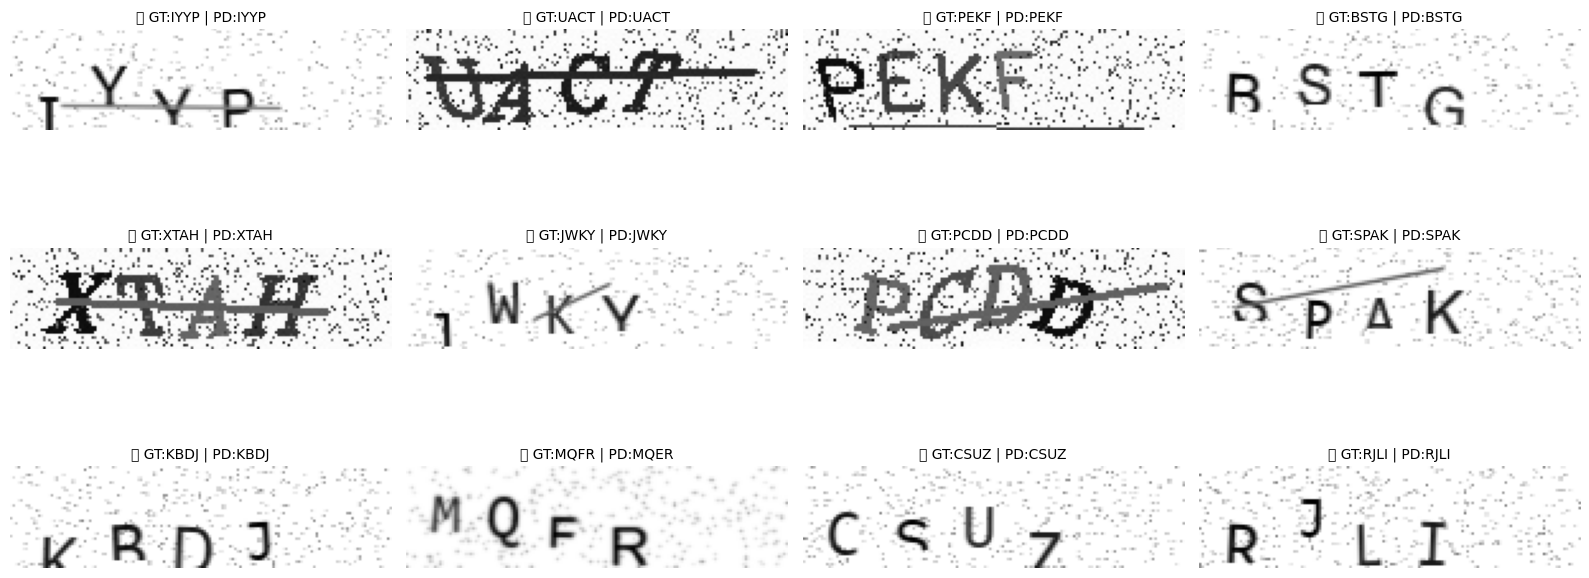

In [ ]:
def show_predictions_grid(model, loader, max_images=12):
    model.eval()
    imgs, gts, pds = [], [], []
    count = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=2).cpu()

            for i in range(images.size(0)):
                gt = decode_indices(labels[i].tolist())
                pd = decode_indices(preds[i].tolist())

                imgs.append(images[i].cpu().squeeze(0).numpy())  # [H, W]
                gts.append(gt)
                pds.append(pd)

                count += 1
                if count >= max_images:
                    break
            if count >= max_images:
                break

    cols = 4
    rows = math.ceil(len(imgs) / cols)
    plt.figure(figsize=(4*cols, 2.5*rows))
    for i, img in enumerate(imgs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow((img * 0.5 + 0.5), cmap="gray")  # de-normalize
        ax.axis("off")
        ok = "✅" if gts[i] == pds[i] else "❌"
        ax.set_title(f"{ok} GT:{gts[i]} | PD:{pds[i]}", fontsize=10)
    plt.tight_layout()
    plt.show()

# Visualize predictions from validation loader using best model (if available)
if best_model is not None and len(val_loader) > 0:
    show_predictions_grid(best_model, val_loader, max_images=12)
else:
    print("No best model or validation data available to visualize.")


/tmp/ipython-input-499926648.py:39: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


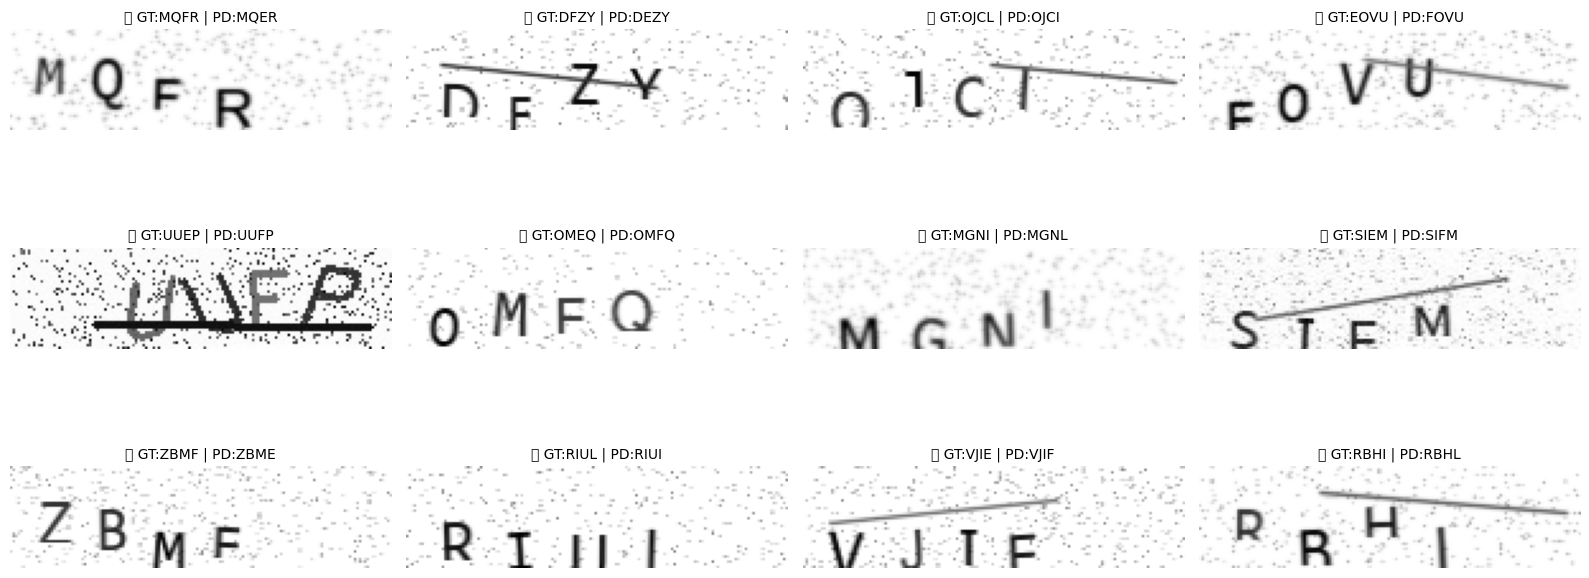

In [ ]:
def show_wrong_predictions(model, loader, max_images=12):
    model.eval()
    imgs, gts, pds = [], [], []
    count = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=2).cpu()

            for i in range(images.size(0)):
                gt = decode_indices(labels[i].tolist())
                pd = decode_indices(preds[i].tolist())

                if gt != pd:  # collect only wrong predictions
                    imgs.append(images[i].cpu().squeeze(0).numpy())  # [H, W]
                    gts.append(gt)
                    pds.append(pd)
                    count += 1

                if count >= max_images:
                    break
            if count >= max_images:
                break

    if len(imgs) == 0:
        print("All predictions are correct! ✅")
        return

    cols = 4
    rows = math.ceil(len(imgs) / cols)
    plt.figure(figsize=(4*cols, 2.5*rows))
    for i, img in enumerate(imgs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow((img * 0.5 + 0.5), cmap="gray")  # de-normalize
        ax.axis("off")
        ax.set_title(f"❌ GT:{gts[i]} | PD:{pds[i]}", fontsize=10)
    plt.tight_layout()
    plt.show()

# Example usage
if best_model is not None and len(val_loader) > 0:
    show_wrong_predictions(best_model, val_loader, max_images=12)
else:
    print("No best model or validation data available to visualize.")


In [ ]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms
import torch


In [ ]:
uploaded = files.upload()  # This will prompt you to choose a file


Saving ACWT_981.png to ACWT_981.png


In [ ]:
# Update size if you used different size in training
transform_test = transforms.Compose([
    transforms.Resize((40, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
for filename in uploaded.keys():
    img = Image.open(filename).convert('L')  # convert to grayscale
    img_tensor = transform_test(img).unsqueeze(0).to(device)  # add batch dimension


In [ ]:
best_model.eval()  # make sure model is in eval mode
with torch.no_grad():
    output = best_model(img_tensor)
    pred_indices = output.argmax(dim=2).squeeze(0).cpu().tolist()
    predicted_text = decode_indices(pred_indices)

print(f"Predicted CAPTCHA: {predicted_text}")


Predicted CAPTCHA: ACWT


In [23]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

# Extract the zip
zip_path = list(uploaded.keys())[0]  # gets the uploaded zip filename
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("test_captchas")

# Now "test_captchas" folder contains all images
print("Extracted files:", os.listdir("test_captchas")[:10])


Saving captcha_test.zip to captcha_test.zip
Extracted files: ['FFBL_9176.png', 'CALI_1073.png', 'GWYL_4803.png', 'OFHS_430.png', 'SYJD_4086.png', 'GGHV_5045.png', 'NZMJ_1145.png', 'JVDY_3384.png', 'YERF_7377.png', 'BZEB_389.png']


In [24]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch

# Path to your folder
test_folder = "/content/test_captchas"

# Same transform as during training
transform_test = transforms.Compose([
    transforms.Resize((40, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

best_model.eval()

# Counters
total_seq = 0
correct_seq = 0
total_chars = 0
correct_chars = 0

for filename in os.listdir(test_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Extract ground-truth from filename
        # Example: ABCD_12345.png → "ABCD"
        gt_text = filename.split("_")[0]

        img_path = os.path.join(test_folder, filename)
        img = Image.open(img_path).convert('L')  # grayscale
        img_tensor = transform_test(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = best_model(img_tensor)  # [1, num_chars, num_classes]
            pred_indices = output.argmax(dim=2).squeeze(0).cpu().tolist()
            predicted_text = decode_indices(pred_indices)

        print(f"{filename} -> Pred: {predicted_text}, GT: {gt_text}")

        # --- Sequence-level accuracy ---
        if predicted_text == gt_text:
            correct_seq += 1
        total_seq += 1

        # --- Character-level accuracy ---
        for p_char, g_char in zip(predicted_text, gt_text):
            if p_char == g_char:
                correct_chars += 1
            total_chars += 1

# Final results
if total_seq > 0:
    seq_acc = 100 * correct_seq / total_seq
    char_acc = 100 * correct_chars / total_chars if total_chars > 0 else 0.0
    print(f"\n📊 Results on Test Folder:")
    print(f" - Sequence Accuracy: {seq_acc:.2f}% ({correct_seq}/{total_seq})")
    print(f" - Character Accuracy: {char_acc:.2f}% ({correct_chars}/{total_chars})")
else:
    print("No valid images found in test folder.")


Streaming output truncated to the last 5000 lines.
BSVU_5523.png -> Pred: BVVU, GT: BSVU
DEZQ_5954.png -> Pred: DEZQ, GT: DEZQ
WCCV_434.png -> Pred: VCCV, GT: WCCV
GNOO_6309.png -> Pred: GNUD, GT: GNOO
QMXR_4872.png -> Pred: QMXR, GT: QMXR
TXDK_1633.png -> Pred: TXDK, GT: TXDK
UZUM_399.png -> Pred: UZUM, GT: UZUM
LJPU_9068.png -> Pred: LJPU, GT: LJPU
XCQV_4669.png -> Pred: XTQV, GT: XCQV
HYRL_9906.png -> Pred: HYRL, GT: HYRL
UPIG_1439.png -> Pred: UPLG, GT: UPIG
DDZJ_6683.png -> Pred: DDZJ, GT: DDZJ
TYQI_1691.png -> Pred: TYDI, GT: TYQI
YFER_7524.png -> Pred: YEER, GT: YFER
EXIU_7405.png -> Pred: EXCU, GT: EXIU
XMQD_2942.png -> Pred: XNQD, GT: XMQD
VCHV_1556.png -> Pred: UCHV, GT: VCHV
OILY_8578.png -> Pred: CGEY, GT: OILY
NRKF_5793.png -> Pred: NRRF, GT: NRKF
DEVG_164.png -> Pred: DEVG, GT: DEVG
NWEG_1758.png -> Pred: NWEG, GT: NWEG
PNEB_3763.png -> Pred: PNEP, GT: PNEB
GMLL_4444.png -> Pred: NMLX, GT: GMLL
SART_719.png -> Pred: PQRT, GT: SART
NSUW_3795.png -> Pred: NSUW, GT: NSUW
ECC

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, charset):
    y_true_chars = []
    y_pred_chars = []

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)

            # Forward pass
            outputs = model(X)  # shape: (T, batch, num_classes)
            outputs = outputs.cpu().numpy()

            # Use best path decoding (greedy)
            pred_indices = np.argmax(outputs, axis=2).T  # (batch, T)

            for true_seq, pred_seq in zip(y, pred_indices):
                true_text = ''.join([charset[idx] for idx in true_seq if idx != -1])
                pred_text = ''.join([charset[idx] for idx in pred_seq if idx != -1])

                # Compare char by char (truncate to min length)
                min_len = min(len(true_text), len(pred_text))
                for t, p in zip(true_text[:min_len], pred_text[:min_len]):
                    y_true_chars.append(t)
                    y_pred_chars.append(p)

    # Confusion matrix
    cm = confusion_matrix(y_true_chars, y_pred_chars, labels=charset)
    return cm


In [ ]:
# Define your character set
import string

# Example: uppercase + digits
CHARSET = list(string.ascii_uppercase)

# Make a mapping from char to index and index to char
char_to_idx = {char: idx for idx, char in enumerate(CHARSET)}
idx_to_char = {idx: char for idx, char in enumerate(CHARSET)}

print("Charset:", CHARSET)
print("Charset size:", len(CHARSET))


Charset: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Charset size: 26


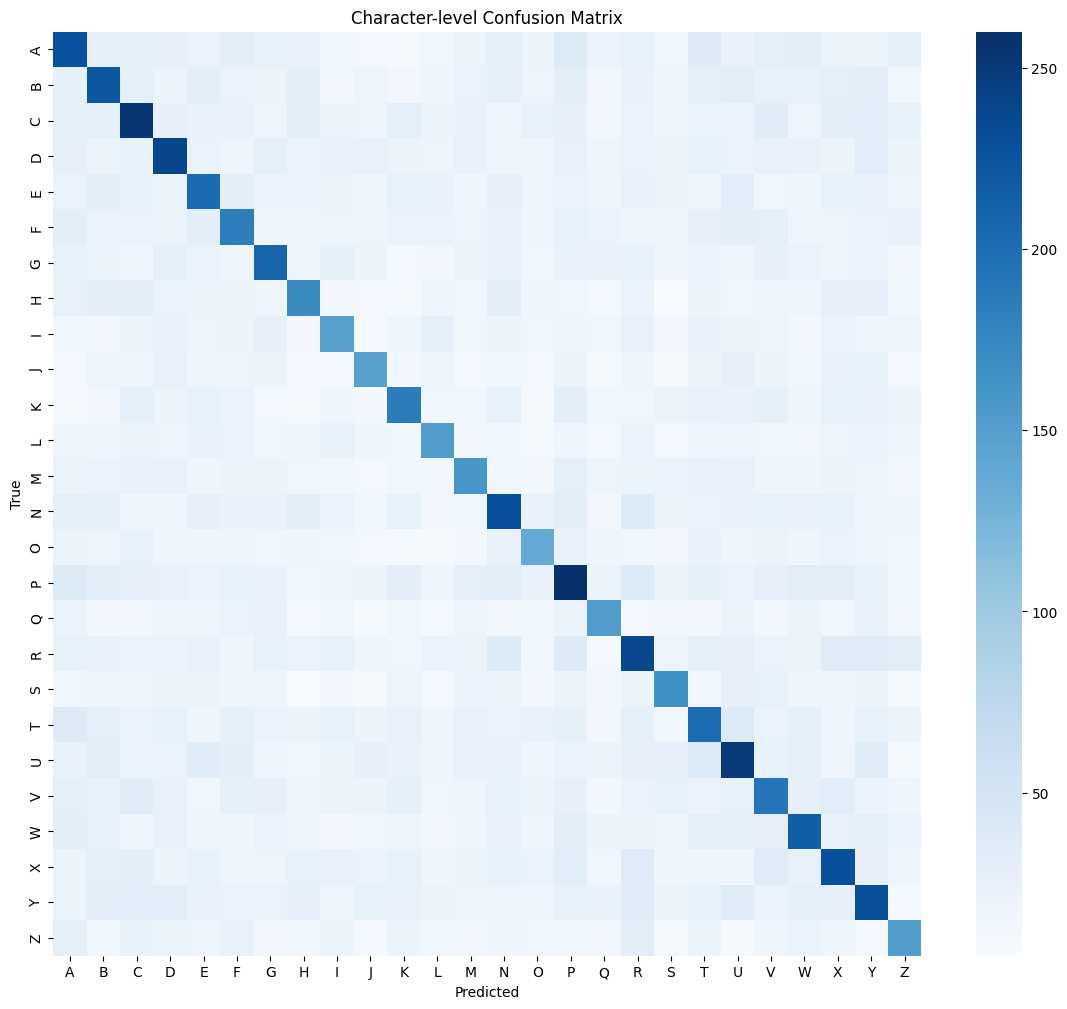

In [ ]:
cm = evaluate_model(best_model, val_loader, CHARSET)

plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=CHARSET, yticklabels=CHARSET)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Character-level Confusion Matrix")
plt.show()


In [ ]:
import time

def measure_latency(model, data_loader, num_batches=100):
    model.eval()
    start = time.time()

    with torch.no_grad():
        for i, (images, _) in enumerate(data_loader):
            images = images.to(device)
            _ = model(images)
            if i >= num_batches:
                break
    end = time.time()
    avg_time = (end - start) / num_batches
    print(f"⏱ Avg latency per batch: {avg_time:.4f} sec")
    return avg_time


In [ ]:
torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    for images, _ in val_loader:
        _ = model(images.to(device))
        break  # just one batch
print(f"Peak GPU memory: {torch.cuda.max_memory_allocated(device)/1024**2:.2f} MB")


Peak GPU memory: 210.61 MB


In [ ]:
print(f"Allocated: {torch.cuda.memory_allocated(device)/1024**2:.2f} MB")
print(f"Cached:    {torch.cuda.memory_reserved(device)/1024**2:.2f} MB")


Allocated: 92.73 MB
Cached:    476.00 MB


In [ ]:
cm = evaluate_model(best_model, val_loader, CHARSET)
latency = measure_latency(best_model, val_loader)


⏱ Avg latency per batch: 0.0312 sec


In [27]:
def visualize_feature_maps(model, img_tensor, layer_name="features.0"):
    """
    Visualize feature maps from a given CNN layer.
    Example layer_name: 'features.0' (1st conv), 'features.4' (2nd conv), etc.
    """
    activation = {}

    def hook_fn(module, input, output):
        activation["output"] = output.detach().cpu()

    # Register hook on target layer
    layer = dict([*model.named_modules()])[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    # Run one forward pass
    _ = model(img_tensor.unsqueeze(0).to(device))

    # Remove hook
    hook.remove()

    # Get activations
    act = activation["output"].squeeze(0)  # [num_filters, H, W]
    num_features = act.shape[0]

    # Plot first 8 feature maps
    fig, axes = plt.subplots(1, min(8, num_features), figsize=(15, 5))
    for i in range(min(8, num_features)):
        axes[i].imshow(act[i], cmap="viridis")
        axes[i].axis("off")
    plt.show()


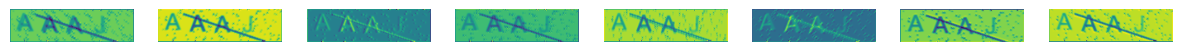

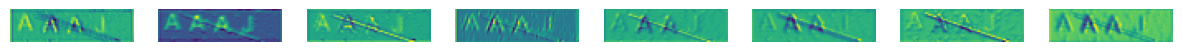

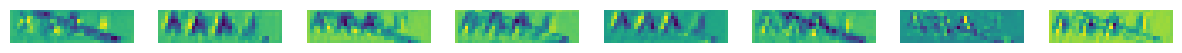

In [28]:
img_path = "/content/test_captchas/AAAJ_9809.png"
img = Image.open(img_path).convert('L')
img_tensor = transform_test(img)

# First conv layer (Conv2d(1, 32, ...))
visualize_feature_maps(best_model, img_tensor, layer_name="features.0")

# Second conv layer (Conv2d(32, 64, ...))
visualize_feature_maps(best_model, img_tensor, layer_name="features.4")

# Third conv layer (Conv2d(64, 128, ...))
visualize_feature_maps(best_model, img_tensor, layer_name="features.8")


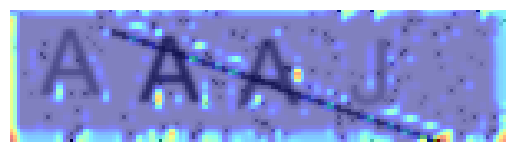

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

def gradcam_no_hooks(model, img_tensor, target_layer="features.4", char_pos=0):
    """
    Grad-CAM that avoids backward hooks entirely.
    - target_layer: e.g., 'features.0', 'features.4', 'features.8', 'features.12', 'features.16'
    - char_pos: which character position (0..num_chars-1) to visualize
    """
    model.eval()
    activations = {}

    # forward hook to capture activations at target_layer
    layer = dict([*model.named_modules()])[target_layer]
    handle = layer.register_forward_hook(lambda m, i, o: activations.setdefault("value", o))

    # forward pass
    x = img_tensor.unsqueeze(0).to(device)  # [1,1,H,W]
    out = model(x)                          # [1, num_chars, num_classes]

    # choose class index for the specified character position
    class_idx = out.argmax(dim=2)[0, char_pos].item()
    loss = out[0, char_pos, class_idx]

    # gradients of loss w.r.t. activations (no backward hook needed)
    model.zero_grad()
    grads = torch.autograd.grad(loss, activations["value"], retain_graph=False, create_graph=False)[0]  # [1,C,h,w]

    # cleanup hook
    handle.remove()

    acts  = activations["value"].detach()[0]  # [C,h,w]
    grads = grads.detach()[0]                  # [C,h,w]

    # global-average-pool grads over spatial dims to get weights per channel
    weights = grads.mean(dim=(1, 2))          # [C]

    # weighted sum of activation maps
    cam = (weights[:, None, None] * acts).sum(dim=0)  # [h,w]
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    # upsample CAM to input size
    cam_up = F.interpolate(cam[None, None, ...], size=(x.shape[2], x.shape[3]),
                           mode="bilinear", align_corners=False).squeeze().cpu().numpy()

    # overlay
    plt.imshow(x[0,0].detach().cpu(), cmap="gray")
    plt.imshow(cam_up, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()

# Example:
gradcam_no_hooks(best_model, img_tensor, target_layer="features.4", char_pos=0)


In [37]:
# Shallow conv layer
gradcam(best_model, img_tensor, target_layer="features.0")

# Mid conv layer
gradcam(best_model, img_tensor, target_layer="features.4")

# Deep conv layer
gradcam(best_model, img_tensor, target_layer="features.12")


RuntimeError: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.